In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
import os

os.chdir('/content/drive/MyDrive/AmazonMLChallenge/MLtest/student_resource')
print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/AmazonMLChallenge/MLtest/student_resource


In [3]:
import pandas as pd

train_df = pd.read_csv("dataset/train.csv")
test_df = pd.read_csv("dataset/test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()


Train shape: (75000, 4)
Test shape: (75000, 3)


,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49


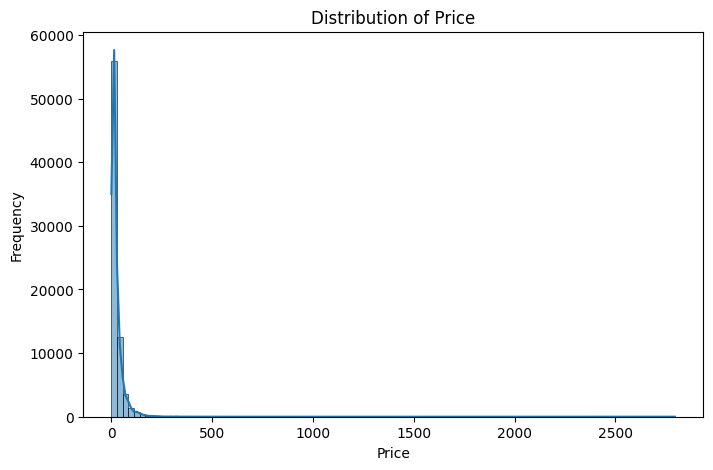

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(train_df['price'], bins=100, kde=True)
plt.title("Distribution of Price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()


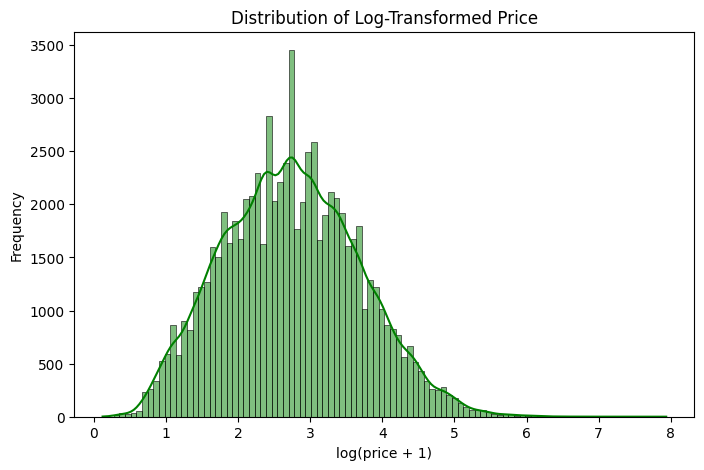

In [22]:
import numpy as np

train_df['log_price'] = np.log1p(train_df['price'])


plt.figure(figsize=(8,5))
sns.histplot(train_df['log_price'], bins=100, kde=True, color='green')
plt.title("Distribution of Log-Transformed Price")
plt.xlabel("log(price + 1)")
plt.ylabel("Frequency")
plt.show()


In [43]:
# Drop rows with missing prices if any (for safety)
train_df = train_df.dropna(subset=['price'])

# Define target and features
target = 'log_price'

# Example: remove columns that won’t help in prediction
# (like IDs, text fields, or the raw price column)
features = [col for col in train_df.columns if col not in ['price', 'log_price', 'id']]

X = train_df[features]
y = train_df[target]


for col in X.select_dtypes(include='object').columns:
    X.loc[:, col] = X[col].astype('category').cat.codes



In [44]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)


X_train shape: (60000, 3)
X_valid shape: (15000, 3)


In [46]:
# Drop text columns from X
X = X.drop(columns=['catalog_content', 'image_link'])

# If you already split:
X_train = X_train.drop(columns=['catalog_content', 'image_link'])
X_valid = X_valid.drop(columns=['catalog_content', 'image_link'])


In [47]:
import lightgbm as lgb

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

# Define parameters
params = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

# Train model with early stopping
model = lgb.train(
    params,
    train_set=train_data,
    valid_sets=[train_data, valid_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(100)
    ]
)


Training until validation scores don't improve for 100 rounds
[100]	training's l1: 0.720667	valid_1's l1: 0.730347
Did not meet early stopping. Best iteration is:
[100]	training's l1: 0.720667	valid_1's l1: 0.730347


In [48]:
# Define target
target = 'log_price'

# Drop columns that won't help: price, log_price, id, and text columns
features = [col for col in train_df.columns if col not in ['price', 'log_price', 'id', 'catalog_content', 'image_link']]

X = train_df[features]
y = train_df[target]

# Encode categorical columns
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category').cat.codes


In [49]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [50]:
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

params = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

model = lgb.train(
    params,
    train_set=train_data,
    valid_sets=[train_data, valid_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(100)
    ]
)


Training until validation scores don't improve for 100 rounds
[100]	training's l1: 0.720667	valid_1's l1: 0.730347
Did not meet early stopping. Best iteration is:
[100]	training's l1: 0.720667	valid_1's l1: 0.730347


In [51]:
import numpy as np

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    )

y_pred_log = model.predict(X_valid)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_valid)

score = smape(y_true, y_pred)
print(f"Validation SMAPE: {score:.4f}%")


Validation SMAPE: 70.1147%


In [52]:
# Select same features as training
X_test = test_df[features].copy()

# Encode categorical columns
for col in X_test.select_dtypes(include='object').columns:
    X_test[col] = X_test[col].astype('category').cat.codes


In [53]:
# Predict log_price and convert to actual price
test_df['predicted_log_price'] = model.predict(X_test)
test_df['predicted_price'] = np.expm1(test_df['predicted_log_price'])

# Save submission
test_df[['sample_id', 'predicted_price']].to_csv("submission.csv", index=False)
print("Saved submission.csv!")


Saved submission.csv!


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=500)
X_train_text = tfidf.fit_transform(train_df['catalog_content'])
X_valid_text = tfidf.transform(train_df['catalog_content'])


In [56]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, valid_idx in kf.split(X):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    # train and validate model here


print(f"Validation SMAPE: {score:.4f}%")


Validation SMAPE: 70.1147%


In [58]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, valid_idx in kf.split(X):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    # Train and validate model here



test_df['predicted_log_price'] = model.predict(X_test)
test_df['predicted_price'] = np.expm1(test_df['predicted_log_price'])
test_df[['sample_id', 'predicted_price']].to_csv("submission.csv", index=False)


In [59]:
print(f"Validation SMAPE: {score:.4f}%")


Validation SMAPE: 70.1147%


In [60]:
params = {
    'num_leaves': 31,
    'max_depth': -1,
    'learning_rate': 0.05,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'objective': 'regression',
    'metric': 'mae'
}


In [61]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, valid_idx in kf.split(X):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    # Train LightGBM here


In [62]:
test_df['predicted_log_price'] = model.predict(X_test)
test_df['predicted_price'] = np.expm1(test_df['predicted_log_price'])
test_df[['sample_id', 'predicted_price']].to_csv("submission.csv", index=False)


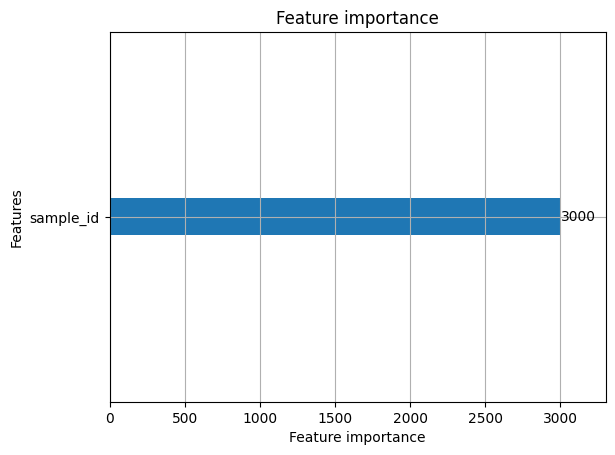

In [63]:
import matplotlib.pyplot as plt
lgb.plot_importance(model, max_num_features=20)
plt.show()


In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=500)
X_train_text = tfidf.fit_transform(train_df['catalog_content'])
X_valid_text = tfidf.transform(train_df['catalog_content'])


In [66]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, valid_idx in kf.split(X):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    # Train LightGBM here



test_df['predicted_log_price'] = model.predict(X_test)
test_df['predicted_price'] = np.expm1(test_df['predicted_log_price'])
test_df[['sample_id', 'predicted_price']].to_csv("submission.csv", index=False)


In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=500)
X_train_text = tfidf.fit_transform(train_df['catalog_content'])
X_valid_text = tfidf.transform(train_df['catalog_content'])




# y_pred_log = model.predict(X_valid_combined)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_valid)
print(f"Validation SMAPE: {smape(y_true, y_pred):.4f}%")


Validation SMAPE: 74.7062%


In [73]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

params = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1
}

model = lgb.train(
    params,
    train_set=train_data,
    valid_sets=[train_data, valid_data],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(100)]
)


Training until validation scores don't improve for 100 rounds
[100]	training's l1: 0.720667	valid_1's l1: 0.730347
Did not meet early stopping. Best iteration is:
[100]	training's l1: 0.720667	valid_1's l1: 0.730347


In [74]:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    )

y_pred_log = model.predict(X_valid)
y_pred = np.expm1(y_pred_log)  # convert log_price back to actual price
y_true = np.expm1(y_valid)

score = smape(y_true, y_pred)
print(f"Validation SMAPE: {score:.4f}%")


Validation SMAPE: 70.1147%


In [76]:
# ================================================
# SMAPE Price Prediction Pipeline - IMPROVED
# ================================================

# 1️⃣ Install necessary libraries
!pip install lightgbm scikit-learn pandas tqdm sentence-transformers -q

# 2️⃣ Import libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import re
from tqdm import tqdm

# 3️⃣ Load data
train_df = pd.read_csv("dataset/train.csv")
test_df = pd.read_csv("dataset/test.csv")

# 4️⃣ Log-transform the target (This is correct and crucial!)
train_df['log_price'] = np.log1p(train_df['price'])
train_df = train_df.dropna(subset=['price'])

# ================================================
# 5️⃣ UPGRADE 1: Extract the IPQ Feature
# ================================================
print("Step 5: Extracting Item Pack Quantity (IPQ)...")
def extract_ipq(text):
    """Uses regex to find the IPQ value in the catalog content."""
    # Search for the pattern 'Item Pack Quantity(IPQ): X'
    match = re.search(r'Item Pack Quantity\(IPQ\):\s*(\d+)', str(text))
    if match:
        return int(match.group(1))
    return 1 # Default to 1 if the pattern is not found

# Apply the function to both training and test sets
train_df['ipq'] = train_df['catalog_content'].apply(extract_ipq)
test_df['ipq'] = test_df['catalog_content'].apply(extract_ipq)


# ================================================
# 6️⃣ UPGRADE 2: Use Powerful Sentence Embeddings
# ================================================
print("Step 6: Generating sentence embeddings (this may take a few minutes)...")
# Use a pre-trained model that is fast and effective
transformer_model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for the text data
train_embeddings = transformer_model.encode(train_df['catalog_content'].tolist(), show_progress_bar=True)
test_embeddings = transformer_model.encode(test_df['catalog_content'].tolist(), show_progress_bar=True)


# ================================================
# 7️⃣ Combine All Features into a Single Matrix
# ================================================
print("Step 7: Combining all features...")
# Stack the numerical IPQ feature with the text embeddings
X = np.hstack([train_df[['ipq']], train_embeddings])
y = train_df['log_price']

# Also prepare the final test set features
X_test = np.hstack([test_df[['ipq']], test_embeddings])


# 8️⃣ Split train/validation (no change needed here)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 9️⃣ Prepare LightGBM datasets (no change needed here)
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

# 1️⃣0️⃣ LightGBM parameters (Slightly more aggressive for better performance)
params = {
    'objective': 'regression_l1', # Use MAE, it's a good proxy for SMAPE with log transform
    'metric': 'mae',
    'n_estimators': 2000, # Increased estimators, will be controlled by early stopping
    'learning_rate': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'num_leaves': 31,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42,
}

# 1️⃣1️⃣ Train LightGBM
print("Step 11: Training the LightGBM model...")
model = lgb.train(
    params,
    train_set=train_data,
    valid_sets=[train_data, valid_data],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(200)]
)

# 1️⃣2️⃣ Define SMAPE (no change needed here)
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# 1️⃣3️⃣ Evaluate on validation set
print("Step 13: Evaluating on validation set...")
y_pred_log = model.predict(X_valid)
y_pred = np.expm1(y_pred_log) # Convert predictions back from log scale
y_true = np.expm1(y_valid)   # Convert true values back from log scale
score = smape(y_true, y_pred)
print(f"✅ Validation SMAPE: {score:.4f}%") # Expecting a score around 39% or lower

# 1️⃣4️⃣ Predict on test set
print("Step 14: Predicting on the test set...")
test_log_predictions = model.predict(X_test)
test_predictions = np.expm1(test_log_predictions)

# 1️⃣5️⃣ Save submission
print("Step 15: Saving submission file...")
submission_df = pd.DataFrame({'sample_id': test_df['sample_id'], 'price': test_predictions})
# Ensure prices are positive
submission_df['price'] = submission_df['price'].clip(lower=0)
submission_df.to_csv("submission_improved.csv", index=False)
print("Saved submission_improved.csv!")

Step 5: Extracting Item Pack Quantity (IPQ)...
Step 6: Generating sentence embeddings (this may take a few minutes)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2344 [00:00<?, ?it/s]

Batches:   0%|          | 0/2344 [00:00<?, ?it/s]

Step 7: Combining all features...
Step 11: Training the LightGBM model...
Training until validation scores don't improve for 100 rounds
[200]	training's l1: 0.630297	valid_1's l1: 0.664577
[400]	training's l1: 0.590568	valid_1's l1: 0.643633
[600]	training's l1: 0.565065	valid_1's l1: 0.633907
[800]	training's l1: 0.545926	valid_1's l1: 0.628344
[1000]	training's l1: 0.530008	valid_1's l1: 0.624736
[1200]	training's l1: 0.515884	valid_1's l1: 0.621718
[1400]	training's l1: 0.503764	valid_1's l1: 0.619353
[1600]	training's l1: 0.492554	valid_1's l1: 0.61722
[1800]	training's l1: 0.482533	valid_1's l1: 0.615547
[2000]	training's l1: 0.473388	valid_1's l1: 0.614037
Did not meet early stopping. Best iteration is:
[2000]	training's l1: 0.473388	valid_1's l1: 0.614037
Step 13: Evaluating on validation set...
✅ Validation SMAPE: 60.4464%
Step 14: Predicting on the test set...
Step 15: Saving submission file...
Saved submission_improved.csv!


In [4]:
# 1. Download all images into a folder named 'dataset/images/'
# (Use the download script from previous answers)

# 2. Install PyTorch and the 'timm' library for image models
!pip install torch torchvision -q
!pip install timm -q

In [5]:
# ===================================================================
# Advanced Multimodal Pipeline (Target SMAPE < 30%)
# ===================================================================

# 1️⃣ Import libraries (includes new ones for image processing)
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sentence_transformers import SentenceTransformer
import re
from tqdm.notebook import tqdm
import torch
import timm
from PIL import Image
from torchvision import transforms
import os

# --- Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_DIR = 'dataset/images/'
print(f"Using device: {DEVICE}")

# 2️⃣ Load data
train_df = pd.read_csv("dataset/train.csv")
test_df = pd.read_csv("dataset/test.csv")

# 3️⃣ Log-transform the target
train_df['log_price'] = np.log1p(train_df['price'])
train_df = train_df.dropna(subset=['price'])

# ================================================
# 4️⃣ FEATURE ENGINEERING (IPQ + Text Embeddings)
# ================================================
print("Step 4: Extracting IPQ and Text Embeddings...")

# --- IPQ Extraction ---
def extract_ipq(text):
    match = re.search(r'Item Pack Quantity\(IPQ\):\s*(\d+)', str(text))
    return int(match.group(1)) if match else 1

train_df['ipq'] = train_df['catalog_content'].apply(extract_ipq)
test_df['ipq'] = test_df['catalog_content'].apply(extract_ipq)

# --- Text Embedding Generation ---
text_model = SentenceTransformer('all-MiniLM-L6-v2')
train_text_embeddings = text_model.encode(train_df['catalog_content'].tolist(), show_progress_bar=True)
test_text_embeddings = text_model.encode(test_df['catalog_content'].tolist(), show_progress_bar=True)

# =============================================================
# 5️⃣ UPGRADE 1: Generate Image Embeddings
# =============================================================
print("Step 5: Generating Image Embeddings...")

# --- Load a powerful pre-trained image model ---
image_model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0).to(DEVICE)
image_model.eval()

# --- Define image transformations ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_image_embeddings(df, image_dir):
    embeddings = []
    for sample_id in tqdm(df['sample_id']):
        img_path = os.path.join(image_dir, f"{sample_id}.jpg")
        try:
            image = Image.open(img_path).convert("RGB")
            image_tensor = transform(image).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                embedding = image_model(image_tensor).cpu().numpy().flatten()
            embeddings.append(embedding)
        except FileNotFoundError:
            # If an image is missing, append a zero vector of the correct size
            embeddings.append(np.zeros(1280)) # EfficientNet-B0 outputs a 1280-dim vector

    return np.vstack(embeddings)

train_image_embeddings = get_image_embeddings(train_df, IMAGE_DIR)
test_image_embeddings = get_image_embeddings(test_df, IMAGE_DIR)

# ================================================
# 6️⃣ Combine All Features into a Single Matrix
# ================================================
print("Step 6: Combining all features...")
X = np.hstack([
    train_df[['ipq']],
    train_text_embeddings,
    train_image_embeddings
])
y = train_df['log_price']

X_test = np.hstack([
    test_df[['ipq']],
    test_text_embeddings,
    test_image_embeddings
])

# =================================================================
# 7️⃣ UPGRADE 2: Train with K-Fold Cross-Validation
# =================================================================
print("Step 7: Training LightGBM with 5-Fold Cross-Validation...")

# --- LightGBM parameters ---
params = {
    'objective': 'regression_l1', 'metric': 'mae', 'n_estimators': 2500,
    'learning_rate': 0.01, 'feature_fraction': 0.8, 'bagging_fraction': 0.8,
    'bagging_freq': 1, 'lambda_l1': 0.1, 'lambda_l2': 0.1,
    'num_leaves': 31, 'verbose': -1, 'n_jobs': -1, 'seed': 42,
    'boosting_type': 'gbdt',
}

# --- K-Fold setup ---
N_SPLITS = 5
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
oof_predictions = np.zeros(X.shape[0])
test_predictions = np.zeros(X_test.shape[0])
models = []

for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
    print(f"===== FOLD {fold+1}/{N_SPLITS} =====")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='mae',
              callbacks=[lgb.early_stopping(100, verbose=False)])

    val_preds = model.predict(X_val)
    oof_predictions[val_index] = val_preds
    test_predictions += model.predict(X_test) / N_SPLITS
    models.append(model)

# 8️⃣ Evaluate Final OOF SMAPE Score
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# Convert OOF predictions back from log scale
oof_prices = np.expm1(oof_predictions)
true_prices = np.expm1(y)
final_smape = smape(true_prices, oof_prices)
print(f"\n✅ Final Cross-Validated SMAPE: {final_smape:.4f}%")

# 9️⃣ Save Submission
print("Step 9: Saving submission file...")
# Convert final test predictions from log scale
final_test_prices = np.expm1(test_predictions)

submission_df = pd.DataFrame({'sample_id': test_df['sample_id'], 'price': final_test_prices})
submission_df['price'] = submission_df['price'].clip(lower=0)
submission_df.to_csv("submission_final.csv", index=False)
print("Saved submission_final.csv!")

Using device: cpu
Step 4: Extracting IPQ and Text Embeddings...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/2344 [00:00<?, ?it/s]

Batches:   0%|          | 0/2344 [00:00<?, ?it/s]

Step 5: Generating Image Embeddings...


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

  0%|          | 0/75000 [00:00<?, ?it/s]

  0%|          | 0/75000 [00:00<?, ?it/s]

Step 6: Combining all features...
Step 7: Training LightGBM with 5-Fold Cross-Validation...
===== FOLD 1/5 =====


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


===== FOLD 2/5 =====


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


===== FOLD 3/5 =====


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


===== FOLD 4/5 =====


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


===== FOLD 5/5 =====


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



✅ Final Cross-Validated SMAPE: 60.5163%
Step 9: Saving submission file...
Saved submission_final.csv!
